In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os.path
import access_data 
import preprocessing
import setting
import feature
import sys

from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor,\
RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier

pd.set_option('display.max_columns' ,1000)
pd.set_option('display.max_rows',60)
%matplotlib inline
reload(feature)

<module 'feature' from 'feature.pyc'>

#清理 + 分词 + label encode+计算词频

In [3]:
train_corpus ,test_corpus = preprocessing.clean_corpus()

test_corpus['corpus'] = preprocessing.segment_word(test_corpus['corpus'])
train_corpus['corpus'] = preprocessing.segment_word(train_corpus['corpus'])

train_corpus.to_pickle(setting.processed_data_dir+'cleaned&segment_train')
test_corpus.to_pickle(setting.processed_data_dir+'cleaned&segment_test')

train_uid,test_uid = preprocessing.encode_label()

preprocessing.bag_of_word(train_corpus['corpus'].values,test_corpus['corpus'].values,min_df=10)

INFO:root:finished cleaning symbol http[0-9a-zA-Z?:=._@%/\-#&\+|]+
INFO:root:finished cleaning symbol //@
INFO:root:finished cleaning symbol @
INFO:root:finished cleaning symbol #
INFO:root:finished cleaning symbol 【
INFO:root:finished cleaning symbol 《
INFO:root:finished cleaning symbol \[


  ##构建用户基本特征 

In [2]:
train_uid = access_data.load_processed_data('uid&pid_train')
test_uid  = access_data.load_processed_data('uid&pid_test')

train ,test = access_data.load_raw_data()

train_corpus = access_data.load_processed_data('cleaned&segment_train')
test_corpus  = access_data.load_processed_data('cleaned&segment_test')                                               
train = pd.concat([train_uid,train,train_corpus],axis=1)
test  = pd.concat([test_uid,test,test_corpus],axis=1)

train.drop([0,1],axis=1,inplace=True)
test.drop([0,1],axis=1,inplace=True)

train.columns = ['pid','uid','time','share','comment','zan','raw_corpus','clean&segment','链接','//@','@','#','【','《','\[']
test.columns = ['pid','uid','time','raw_corpus','clean&segment','链接','//@','@','#','【','《','\[']
train['uid'] = train['uid'].astype(np.uint16)
test['uid']  = test['uid'].astype(np.uint16)
l = ['链接','//@','@','#','【','《','\[']

for string in l :
    train[string] = train[string].astype(np.int8)
    test[string]  = test[string].astype(np.int8)

#在training set和test set中和用户发送微博的总数量
tot = pd.concat([pd.DataFrame(train['uid']),pd.DataFrame(test['uid'])])
c = pd.DataFrame(tot['uid'].value_counts())
c.columns = ['tot_counts']
train = train.merge(c,left_on='uid',right_index=True,how='left')
test  = test.merge(c,left_on='uid',right_index=True,how='left')

# 用户出现在训练集的次数
c = pd.DataFrame(train['uid'].value_counts())
c.columns = ['train_counts']
train = train.merge(c,left_on='uid',right_index=True,how='left')
test  = test.merge(c,left_on='uid',right_index=True,how='left')

test.fillna(-1,inplace=True)
train['tot_counts'] = train['tot_counts'].astype(np.int32)
train['train_counts'] = train['train_counts'].astype(np.int32)

test['tot_counts'] = test['tot_counts'].astype(np.int32)
test['train_counts'] = test['train_counts'].astype(np.int32)

addr1 = setting.raw_data_dir + 'basic_train'
addr2 = setting.raw_data_dir + 'basic_test'

if not os.path.exists(addr1):
    train.to_pickle(addr1)
if not os.path.exists(addr2):
    test.to_pickle(addr2)

##主题模型

In [ ]:
%run run_lda.py

In [27]:
lda_result = np.load('processed_data/lda_result_version2.npy')
lda_result = pd.DataFrame(lda_result,columns=['topic_%d' %i for i in range(0,25)])

##用户+文本符号统计特征 （min，max，histogram，std，min）

In [3]:
train_user,test_user = feature.user_basic_feature()
train_content,test_content = feature.content_basic_feature()

##时间特征

In [4]:
train_time,test_time = feature.time_feature()

In [10]:
train = train_user.merge(train_content,how='left',left_on='pid',right_index=True)
test  = test_user.merge(test_content,how='left',left_on='pid',right_index=True)

train = train.merge(train_time,how='left',left_on='pid',right_index=True)
test  = test.merge(test_time,how='left',left_on='pid',right_index=True)
train.to_pickle('processed_data/train')
test.to_pickle('processed_data/test')

In [3]:
train = pd.read_pickle('processed_data/train')
test  = pd.read_pickle('processed_data/test')

In [25]:
result_test = []
result_train = []
tot = 0
for string in ['share','comment','zan',]:
    temp = []
    for i in test[string+'_histogram']:
        if isinstance(i,int):
            temp.append(np.zeros(shape=8))
            tot +=1
        else:
            temp.append(i[0])
    result_test.append(np.asarray(temp))
    temp = []
    for i in train[string+'_histogram']:
        temp.append(i[0])
    result_train.append(np.asarray(temp))

#文本特征

In [3]:
def find_string(x):
    if reg.search(x):
        return 1
    else:
        return 0
wenben = ['创业','分享自','知乎','正品','机器学习','大数据','python','公开课','论文','周杰伦','推荐','美女','预约','曝光',\
          '优酷','天气','吐槽','双11','百度钱包','狂欢节','美拍','校园招聘','骚扰他人','人身攻击','有才','余额宝','mysql','客户端',\
          '抢购','降价','优惠活动','《','幸运用户','虾米音乐','过节','嘻嘻','陌陌','签到','死亡','身亡','综合运势','星座','呵呵','看过《',\
          'tmd','TMD','腐败','大红包','反腐','我参与了']
for string in wenben:
    reg  = re.compile(string)
    train[string] = train['content2'].map(find_string)
    test[string] = test['content2'].map(find_string)

In [74]:
 def find_try(x):
    if re.search( '我参与了' ,x):
        return 1
    else :
        return 0
print sum(train.loc[train.share>1]['content2'].map(find_try))
print sum(train.loc[train.comment>0]['content2'].map(find_try))
print sum(train.loc[train.zan>0]['content2'].map(find_try))

47
368
361


#格式转换为narray矩阵

In [29]:
train.columns

Index([u'pid', u'uid', u'time', u'share', u'comment', u'zan', u'raw_corpus',
       u'clean&segment', u'链接', u'//@', u'@', u'#', u'【', u'《', u'\[',
       u'tot_counts', u'train_counts', u'share_mean', u'comment_mean',
       u'zan_mean', u'share_amax', u'comment_amax', u'zan_amax', u'share_amin',
       u'comment_amin', u'zan_amin', u'share_std', u'comment_std', u'zan_std',
       u'share_histogram', u'comment_histogram', u'zan_histogram',
       u'content_len', u'链接_mean', u'//@_mean', u'@_mean', u'#_mean',
       u'【_mean', u'《_mean', u'\[_mean', u'content_len_amax', u'链接_amax',
       u'//@_amax', u'@_amax', u'#_amax', u'【_amax', u'《_amax', u'\[_amax',
       u'content_len_amin', u'链接_amin', u'//@_amin', u'@_amin', u'#_amin',
       u'【_amin', u'《_amin', u'\[_amin', u'content_len_std', u'链接_std',
       u'//@_std', u'@_std', u'#_std', u'【_std', u'《_std', u'\[_std',
       u'content_len_histogram', u'链接_histogram', u'//@_histogram',
       u'@_histogram', u'#_histogram', u'【_histogr

In [32]:
train.drop(['uid','time','raw_corpus','clean&segment'],inplace=True,axis = 1)
test.drop(['uid','time','raw_corpus','clean&segment'],inplace=True,axis = 1)

train_y = train[['share','comment','zan']].values.astype(np.float64)
train.drop(['share','comment','zan'],axis = 1,inplace=True)
train_x = np.c_[train.values,lda_result.loc[:1626749].values]
test_x  = np.c_[test.values,lda_result.loc[1626750:].values]

In [33]:
train_x

array([['5fefc2488f99aba5782baa43096b76dc', 0, 0, ...,
        0.0032786885245901635, 0.0032786885245901635, 0.0032786885245901635],
       ['397d9abe2ebf9ba986fe5ab5a6139e11', 1, 0, ...,
        0.0029850746268656712, 0.0029850746268656712, 0.0029850746268656712],
       ['a2ae3959e9aa21a47993506e2609a4ec', 0, 0, ...,
        0.013333333333333332, 0.013333333333333332, 0.013333333333333332],
       ..., 
       ['ff7f21a750d9e0d4f5469c3cc58a4f41', 1, 0, ..., 0.01818181818181818,
        0.01818181818181818, 0.01818181818181818],
       ['89ddb51947afecefc04957ea36a8dc0d', 0, 0, ...,
        0.006896551724137933, 0.006896551724137933, 0.006896551724137933],
       ['a3513353849669a374eeca4cdb4b03fe', 0, 0, ...,
        0.0064516129032258064, 0.0064516129032258064, 0.0064516129032258064]], dtype=object)

In [5]:
#离散化
train_y_class = np.zeros_like(train_y)
train_y_class[train_y[:,0]>1,0] = 1
train_y_class[train_y[:,1]>0,1] = 1
train_y_class[train_y[:,2]>0,2] = 1
train_y = np.log1p(train_y)

#分类

In [12]:
clf = RandomForestClassifier(n_estimators=400,max_leaf_nodes=10000,max_features=15,n_jobs=4)

In [13]:
clf.fit(train_x,train_y_class)
test_predict = clf.predict(test_x)
test_predict = pd.DataFrame(test_predict)

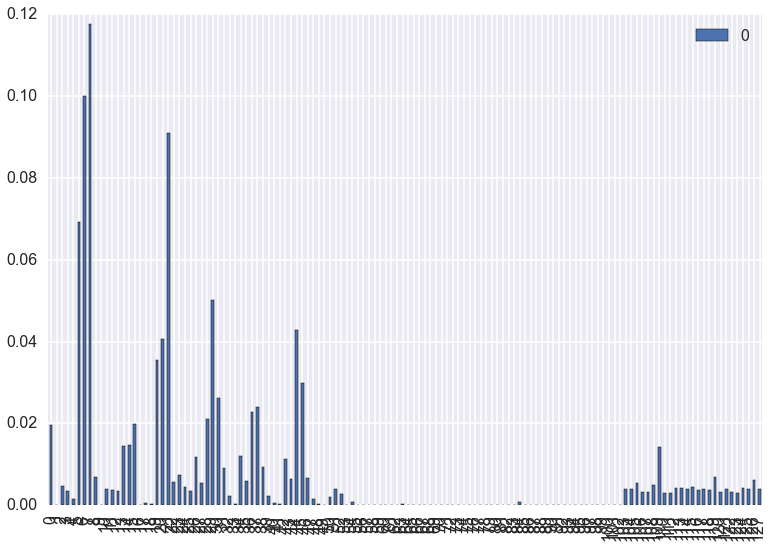

In [15]:
pd.DataFrame(clf.feature_importances_).plot(kind = 'bar')

#回归

In [16]:
for i in range(0,3):
    regressor = RandomForestRegressor(n_estimators=400,max_features=35,max_leaf_nodes=10000,n_jobs=4)
    mask = train_y_class[:,i] >0 
    regressor.fit(train_x[mask],train_y[mask,i])
    test_predict.loc[test_predict[i]>0,i] = regressor.predict(test_x[(test_predict[i]>0).values])

In [17]:
for i in range(0,3):
    test_predict[i] = test_predict[i].map(lambda x:np.rint(np.expm1(x)))

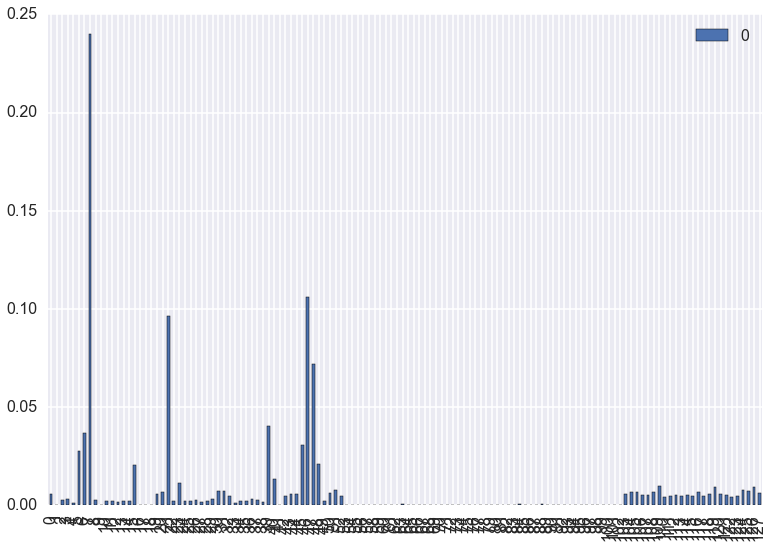

In [19]:
pd.DataFrame(regressor.feature_importances_).plot(kind='bar')

#打印

In [27]:
import access_data
reload(access_data)
docs = dict(classification = 'RF n_estimators=400,max_leaf_nodes=10000,max_features=15 ',
            regression = 'RF n_estimators=400,max_features=35,max_leaf_nodes=10000,n_jobs=4',
            preprocessing = 'np.log1p',
           predict_big_0 = '16302 43168 32005')
access_data.output_result(test_predict,'2015-8-14_2',docs)

In [30]:
np.pad(np.arange(5), (0,4), 'constant')

array([0, 1, 2, 3, 4, 0, 0, 0, 0])

In [34]:
if None :
    print "ok"